In [1]:
import pandas as pd
import numpy as np
import itertools
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from tqdm import tqdm
import joblib

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_mask = y_true != 0
    return np.mean(np.abs((y_true[non_zero_mask] - y_pred[non_zero_mask]) / y_true[non_zero_mask])) * 100

# Create MAPE scorer
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better=False)

# Define the custom TqdmGridSearchCV class
class TqdmGridSearchCV(GridSearchCV):
    def _run_search(self, evaluate_candidates):
        """ Use tqdm with GridSearchCV """
        # Ensure that parameter combinations are a list of tuples
        param_combinations = list(itertools.product(*[self.param_grid[key] for key in sorted(self.param_grid)]))
        for params in tqdm(param_combinations, total=len(param_combinations)):
            evaluate_candidates([dict(zip(sorted(self.param_grid), params))])

# Load the dataset
df_raw = pd.read_csv('Train.csv')

# Convert the 'date_time' column to datetime and sort the dataset
df_raw['date_time'] = pd.to_datetime(df_raw['date_time'])
df_raw.sort_values('date_time', inplace=True)
df_raw.set_index('date_time', inplace=True)

# Extract hour from the 'date_time' column
df_raw['hour'] = df_raw.index.hour

# One-hot encode categorical features
df = pd.get_dummies(df_raw, columns=['is_holiday', 'weather_type', 'weather_description'], drop_first=True)

# Feature engineering: create lagged and rolling features
target = 'traffic_volume'
for i in range(1, 4):
    df[f'traffic_volume_lag_{i}'] = df[target].shift(i)
df['traffic_volume_rolling_mean'] = df[target].rolling(window=3).mean().shift(1)
df['traffic_volume_rolling_std'] = df[target].rolling(window=3).std().shift(1)

# Remove rows with NaN values resulting from lagged features
df.dropna(inplace=True)

# Split the dataset into features and the target
X = df.drop(target, axis=1)
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(target, axis=1), df[target], test_size=0.2, shuffle=False)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# Initialize the XGBoost regressor
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror')

# Initialize the TqdmGridSearchCV object with verbose logging and MAPE scorer
grid_search = TqdmGridSearchCV(estimator=xgboost_model, param_grid=param_grid,
                               scoring=mape_scorer, cv=3, verbose=3)

# Fit the grid search to the scaled training data
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_parameters = grid_search.best_params_

# Print the best parameters
print(f"Best parameters found: {best_parameters}")

# Train the best model on the scaled training data
best_model = grid_search.best_estimator_
best_model.fit(X_train_scaled, y_train)

# Predict on the scaled test set with the best model
y_pred = best_model.predict(X_test_scaled)

# Calculate the metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

traffic_volume_range = df[target].max() - df[target].min()

# Normalize RMSE and MAE
normalized_rmse = rmse / traffic_volume_range
normalized_mae = mae / traffic_volume_range

# Output the metrics
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Normalized Root Mean Squared Error (RMSE): {normalized_rmse}")
print(f"Normalized Mean Absolute Error (MAE): {normalized_mae}")
print(f"R-squared (R2): {r2}")
print(f"Mean Absolute Percentage Error (MAPE): {mape}%")

# Save the best model and the scaler for later use
best_model.save_model('best_xgboost_model.json')
joblib.dump(scaler, 'scaler.save')


  0%|          | 0/243 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-74.077 total time=   0.1s


  0%|          | 1/243 [00:00<02:18,  1.75it/s]

[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-121.653 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-408.670 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-74.155 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-121.478 total time=   0.1s


  1%|          | 2/243 [00:01<02:28,  1.62it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-408.207 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-74.150 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-121.843 total time=   0.1s


  1%|          | 3/243 [00:01<02:26,  1.64it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-409.350 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-37.332 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-74.334 total time=   0.2s


  2%|▏         | 4/243 [00:02<03:03,  1.30it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-298.344 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-37.362 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-74.048 total time=   0.7s


  2%|▏         | 5/243 [00:04<04:13,  1.07s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-300.624 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-37.390 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-73.609 total time=   0.2s


  2%|▏         | 6/243 [00:05<03:53,  1.02it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-301.120 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-24.044 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-53.862 total time=   0.3s


  3%|▎         | 7/243 [00:06<04:13,  1.07s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-268.920 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-24.106 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-54.106 total time=   0.3s


  3%|▎         | 8/243 [00:07<04:29,  1.15s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-268.017 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-24.094 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-53.468 total time=   0.3s


  4%|▎         | 9/243 [00:09<04:37,  1.19s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-259.008 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-70.311 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-106.277 total time=   0.2s


  4%|▍         | 10/243 [00:09<04:12,  1.08s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-433.574 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-70.316 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-105.324 total time=   0.1s


  5%|▍         | 11/243 [00:10<03:48,  1.02it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-420.417 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-70.342 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-105.565 total time=   0.1s


  5%|▍         | 12/243 [00:11<03:26,  1.12it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-429.892 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-32.837 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-56.177 total time=   0.3s


  5%|▌         | 13/243 [00:12<03:56,  1.03s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-329.798 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-32.885 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-54.945 total time=   0.3s


  6%|▌         | 14/243 [00:14<04:17,  1.12s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-308.299 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-32.849 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-54.595 total time=   0.3s


  6%|▌         | 15/243 [00:15<04:23,  1.16s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-319.541 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-19.533 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-35.578 total time=   0.5s


  7%|▋         | 16/243 [00:17<05:17,  1.40s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-295.787 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-19.586 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-35.161 total time=   0.5s


  7%|▋         | 17/243 [00:19<05:47,  1.54s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-273.991 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-19.613 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-34.533 total time=   0.5s


  7%|▋         | 18/243 [00:20<06:01,  1.61s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-300.241 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-69.490 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-110.319 total time=   0.3s


  8%|▊         | 19/243 [00:22<05:28,  1.47s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-427.839 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-69.505 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-105.090 total time=   0.3s


  8%|▊         | 20/243 [00:23<05:05,  1.37s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-432.705 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-69.497 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-105.015 total time=   0.3s


  9%|▊         | 21/243 [00:24<04:49,  1.30s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-425.218 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-31.723 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-57.910 total time=   0.6s


  9%|▉         | 22/243 [00:26<05:43,  1.55s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-326.386 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-31.767 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-54.595 total time=   0.6s


  9%|▉         | 23/243 [00:28<06:20,  1.73s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-328.576 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-31.792 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-54.494 total time=   0.6s


 10%|▉         | 24/243 [00:30<06:44,  1.85s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-314.570 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-18.450 total time=   1.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-40.499 total time=   1.0s


 10%|█         | 25/243 [00:33<08:10,  2.25s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-299.784 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-18.496 total time=   1.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-37.304 total time=   0.9s


 11%|█         | 26/243 [00:37<09:10,  2.54s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-291.441 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-18.480 total time=   0.9s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-39.011 total time=   1.0s


 11%|█         | 27/243 [00:40<09:45,  2.71s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-273.265 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-15.743 total time=   0.1s


 12%|█▏        | 28/243 [00:40<07:19,  2.04s/it]

[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-26.692 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-202.783 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.573 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-30.467 total time=   0.0s


 12%|█▏        | 29/243 [00:41<05:37,  1.58s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-246.872 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.523 total time=   0.1s


 12%|█▏        | 30/243 [00:41<04:24,  1.24s/it]

[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-29.854 total time=   0.0s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-281.392 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-15.319 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-28.182 total time=   0.2s


 13%|█▎        | 31/243 [00:42<03:58,  1.12s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-298.970 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-15.356 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-29.461 total time=   0.2s


 13%|█▎        | 32/243 [00:43<03:37,  1.03s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-265.910 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-15.085 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-32.558 total time=   0.2s


 14%|█▎        | 33/243 [00:44<03:25,  1.02it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-219.792 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-15.123 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-36.426 total time=   0.3s


 14%|█▍        | 34/243 [00:45<03:37,  1.04s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-313.226 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.933 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-27.206 total time=   0.3s


 14%|█▍        | 35/243 [00:46<03:43,  1.08s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-267.785 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.717 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-35.736 total time=   0.2s


 15%|█▍        | 36/243 [00:47<03:42,  1.08s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-215.716 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-13.934 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-28.230 total time=   0.1s


 15%|█▌        | 37/243 [00:48<03:20,  1.03it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-235.149 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-13.648 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-25.281 total time=   0.1s


 16%|█▌        | 38/243 [00:49<03:01,  1.13it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-273.025 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-13.934 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-21.936 total time=   0.1s


 16%|█▌        | 39/243 [00:49<02:49,  1.20it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-295.105 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-13.899 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-32.263 total time=   0.4s


 16%|█▋        | 40/243 [00:51<03:27,  1.02s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-250.667 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-13.680 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-34.821 total time=   0.4s


 17%|█▋        | 41/243 [00:52<03:54,  1.16s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-287.225 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-13.972 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-22.407 total time=   0.3s


 17%|█▋        | 42/243 [00:53<03:53,  1.16s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-303.400 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-14.020 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-34.790 total time=   0.4s


 18%|█▊        | 43/243 [00:55<04:26,  1.33s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-248.175 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-13.789 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-34.950 total time=   0.4s


 18%|█▊        | 44/243 [00:57<04:49,  1.46s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-283.121 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-14.185 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-25.839 total time=   0.5s


 19%|█▊        | 45/243 [00:59<05:06,  1.55s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-300.267 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-12.929 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-33.489 total time=   0.3s


 19%|█▉        | 46/243 [01:00<04:40,  1.42s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-276.095 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-13.048 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-24.561 total time=   0.2s


 19%|█▉        | 47/243 [01:01<04:17,  1.31s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-304.399 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-13.167 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-23.371 total time=   0.3s


 20%|█▉        | 48/243 [01:02<04:06,  1.26s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-228.915 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-13.395 total time=   1.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-34.080 total time=   0.6s


 20%|██        | 49/243 [01:04<05:19,  1.64s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-277.900 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-13.419 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-24.276 total time=   0.5s


 21%|██        | 50/243 [01:06<05:34,  1.73s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-313.565 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-13.450 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-23.583 total time=   0.6s


 21%|██        | 51/243 [01:08<05:47,  1.81s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-246.335 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-13.628 total time=   1.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-33.604 total time=   1.0s


 21%|██▏       | 52/243 [01:12<07:28,  2.35s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-282.150 total time=   1.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-13.617 total time=   1.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-25.566 total time=   1.2s


 22%|██▏       | 53/243 [01:16<08:38,  2.73s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-311.982 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-13.667 total time=   0.9s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-22.534 total time=   1.0s


 22%|██▏       | 54/243 [01:19<08:49,  2.80s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-248.353 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-15.393 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-28.079 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-299.106 total time=   0.1s


 23%|██▎       | 55/243 [01:19<06:38,  2.12s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.293 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-29.437 total time=   0.1s


 23%|██▎       | 56/243 [01:20<05:12,  1.67s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-254.028 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.573 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-21.101 total time=   0.1s
[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-289.589 total time=   0.1s


 23%|██▎       | 57/243 [01:20<04:08,  1.34s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-15.032 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-30.087 total time=   0.2s


 24%|██▍       | 58/243 [01:21<03:47,  1.23s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-199.464 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-14.935 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-29.575 total time=   0.2s


 24%|██▍       | 59/243 [01:22<03:31,  1.15s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-296.157 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-14.756 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-23.490 total time=   0.2s


 25%|██▍       | 60/243 [01:23<03:16,  1.08s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-214.895 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-14.773 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-29.940 total time=   0.4s


 25%|██▌       | 61/243 [01:25<03:33,  1.17s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-196.436 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.664 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-30.544 total time=   0.3s


 26%|██▌       | 62/243 [01:26<03:46,  1.25s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-285.344 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.707 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-41.257 total time=   0.3s


 26%|██▌       | 63/243 [01:27<03:43,  1.24s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-181.179 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-14.278 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-49.351 total time=   0.1s


 26%|██▋       | 64/243 [01:28<03:16,  1.10s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-261.708 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-14.014 total time=   0.2s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-38.085 total time=   0.1s


 27%|██▋       | 65/243 [01:29<02:57,  1.00it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-235.650 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-13.693 total time=   0.1s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-21.114 total time=   0.2s


 27%|██▋       | 66/243 [01:30<02:45,  1.07it/s]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-193.429 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-14.613 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-51.328 total time=   0.4s


 28%|██▊       | 67/243 [01:31<03:14,  1.10s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-257.551 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-14.332 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-36.425 total time=   0.5s


 28%|██▊       | 68/243 [01:33<03:44,  1.28s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-225.747 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-14.166 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-21.321 total time=   0.3s


 28%|██▊       | 69/243 [01:34<03:38,  1.26s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-201.439 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-14.841 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-51.928 total time=   0.5s


 29%|██▉       | 70/243 [01:36<04:06,  1.42s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-249.083 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-14.538 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-37.637 total time=   0.4s


 29%|██▉       | 71/243 [01:37<04:21,  1.52s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-228.672 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-14.609 total time=   0.4s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-21.641 total time=   0.4s


 30%|██▉       | 72/243 [01:39<04:28,  1.57s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-200.770 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-14.675 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-28.115 total time=   0.3s


 30%|███       | 73/243 [01:40<04:10,  1.47s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-274.976 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-13.976 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-21.641 total time=   0.4s


 30%|███       | 74/243 [01:42<04:00,  1.42s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-311.458 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-14.178 total time=   0.3s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-18.326 total time=   0.3s


 31%|███       | 75/243 [01:43<03:43,  1.33s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-329.486 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-15.146 total time=   0.6s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-28.606 total time=   0.7s


 31%|███▏      | 76/243 [01:45<04:25,  1.59s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-283.522 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-14.536 total time=   1.0s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-24.171 total time=   0.6s


 32%|███▏      | 77/243 [01:47<05:06,  1.85s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-307.695 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-14.707 total time=   0.5s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-17.680 total time=   0.5s


 32%|███▏      | 78/243 [01:49<04:57,  1.80s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-335.372 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-15.410 total time=   0.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-29.038 total time=   0.8s


 33%|███▎      | 79/243 [01:52<05:43,  2.09s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-285.297 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-14.886 total time=   0.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-23.336 total time=   0.8s


 33%|███▎      | 80/243 [01:55<06:13,  2.29s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-306.993 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-14.907 total time=   0.8s
[CV 2/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-17.870 total time=   0.7s


 33%|███▎      | 81/243 [01:57<06:20,  2.35s/it]

[CV 3/3] END colsample_bytree=0.8, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-333.587 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-73.756 total time=   0.1s


 34%|███▎      | 82/243 [01:58<04:51,  1.81s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-121.388 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-412.405 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-73.808 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-121.330 total time=   0.1s


 34%|███▍      | 83/243 [01:58<03:48,  1.43s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-411.649 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-73.826 total time=   0.1s


 35%|███▍      | 84/243 [01:59<03:04,  1.16s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-122.169 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-414.633 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-37.165 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-73.896 total time=   0.2s


 35%|███▍      | 85/243 [02:00<02:52,  1.09s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-324.760 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-37.230 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-73.800 total time=   0.2s


 35%|███▌      | 86/243 [02:01<02:44,  1.05s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-319.620 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-37.330 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-73.502 total time=   0.2s


 36%|███▌      | 87/243 [02:02<02:34,  1.01it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-320.991 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-23.848 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-52.787 total time=   0.3s


 36%|███▌      | 88/243 [02:03<02:47,  1.08s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-293.470 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-23.887 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-53.419 total time=   0.3s


 37%|███▋      | 89/243 [02:04<02:56,  1.15s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-286.962 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-23.808 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-52.869 total time=   0.3s


 37%|███▋      | 90/243 [02:05<02:58,  1.17s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-279.066 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-69.890 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-105.818 total time=   0.1s


 37%|███▋      | 91/243 [02:06<02:40,  1.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-451.189 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-69.907 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-105.094 total time=   0.1s


 38%|███▊      | 92/243 [02:07<02:26,  1.03it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-436.877 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-69.907 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-105.168 total time=   0.1s


 38%|███▊      | 93/243 [02:08<02:16,  1.10it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-459.984 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-32.450 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-56.628 total time=   0.3s


 39%|███▊      | 94/243 [02:09<02:35,  1.04s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-342.071 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-32.538 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-55.543 total time=   0.3s


 39%|███▉      | 95/243 [02:10<02:49,  1.15s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-329.596 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-32.481 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-55.058 total time=   0.3s


 40%|███▉      | 96/243 [02:12<02:55,  1.19s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-359.472 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-19.305 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-37.393 total time=   0.6s


 40%|███▉      | 97/243 [02:14<03:27,  1.42s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-312.944 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-19.387 total time=   0.7s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-35.870 total time=   0.6s


 40%|████      | 98/243 [02:16<04:03,  1.68s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-297.842 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-19.342 total time=   0.7s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-35.372 total time=   0.8s


 41%|████      | 99/243 [02:18<04:35,  1.91s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-319.298 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-69.017 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-108.969 total time=   0.3s


 41%|████      | 100/243 [02:20<04:09,  1.75s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-445.558 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-69.030 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-104.425 total time=   0.3s


 42%|████▏     | 101/243 [02:21<03:48,  1.61s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-448.060 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-69.003 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-103.879 total time=   0.3s


 42%|████▏     | 102/243 [02:22<03:32,  1.51s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-437.570 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-31.300 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-56.809 total time=   1.1s


 42%|████▏     | 103/243 [02:25<04:40,  2.00s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-336.661 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-31.309 total time=   0.7s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-53.439 total time=   0.6s


 43%|████▎     | 104/243 [02:28<04:47,  2.07s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-335.123 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-31.333 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-52.610 total time=   0.6s


 43%|████▎     | 105/243 [02:30<04:47,  2.09s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-319.250 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-18.113 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-39.885 total time=   0.9s


 44%|████▎     | 106/243 [02:33<05:27,  2.39s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-302.517 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-18.151 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-36.409 total time=   1.0s


 44%|████▍     | 107/243 [02:36<05:56,  2.62s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-289.860 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-18.172 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-34.494 total time=   0.9s


 44%|████▍     | 108/243 [02:39<06:11,  2.75s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-273.042 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-15.540 total time=   0.0s


 45%|████▍     | 109/243 [02:40<04:36,  2.07s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-27.426 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-288.405 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.385 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-25.011 total time=   0.0s


 45%|████▌     | 110/243 [02:40<03:31,  1.59s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-285.394 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.312 total time=   0.0s


 46%|████▌     | 111/243 [02:41<02:44,  1.24s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-28.300 total time=   0.0s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-298.949 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-15.040 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-29.229 total time=   0.2s


 46%|████▌     | 112/243 [02:41<02:25,  1.11s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-287.430 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-15.092 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-28.137 total time=   0.2s


 47%|████▋     | 113/243 [02:42<02:12,  1.02s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-277.667 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-14.935 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-26.341 total time=   0.1s


 47%|████▋     | 114/243 [02:43<01:59,  1.08it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-284.116 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-14.936 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-37.700 total time=   0.3s


 47%|████▋     | 115/243 [02:44<02:06,  1.01it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-253.260 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.832 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-28.301 total time=   0.4s


 48%|████▊     | 116/243 [02:45<02:18,  1.09s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-258.339 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.770 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-25.693 total time=   0.3s


 48%|████▊     | 117/243 [02:47<02:22,  1.13s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-285.735 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-13.305 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-39.412 total time=   0.2s


 49%|████▊     | 118/243 [02:47<02:10,  1.05s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-277.751 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-13.094 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-35.351 total time=   0.2s


 49%|████▉     | 119/243 [02:48<02:03,  1.01it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-265.549 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-13.347 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-25.447 total time=   0.2s


 49%|████▉     | 120/243 [02:49<01:54,  1.07it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-229.549 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-13.564 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-41.198 total time=   0.4s


 50%|████▉     | 121/243 [02:51<02:15,  1.11s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-303.917 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-13.288 total time=   0.4s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-41.377 total time=   0.4s


 50%|█████     | 122/243 [02:52<02:25,  1.21s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-274.754 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-13.450 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-30.137 total time=   0.3s


 51%|█████     | 123/243 [02:53<02:25,  1.22s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-236.666 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-13.704 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-44.636 total time=   0.5s


 51%|█████     | 124/243 [02:55<02:46,  1.40s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-293.993 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-13.392 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-42.484 total time=   0.6s


 51%|█████▏    | 125/243 [02:57<03:11,  1.62s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-267.726 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-13.588 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-28.569 total time=   0.5s


 52%|█████▏    | 126/243 [02:59<03:15,  1.67s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-236.555 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-12.343 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-34.575 total time=   0.3s


 52%|█████▏    | 127/243 [03:00<02:58,  1.54s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-280.030 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-12.327 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-23.887 total time=   0.3s


 53%|█████▎    | 128/243 [03:01<02:44,  1.43s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-277.880 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-12.453 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-26.742 total time=   0.2s


 53%|█████▎    | 129/243 [03:02<02:30,  1.32s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-281.655 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-12.868 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-34.090 total time=   0.6s


 53%|█████▎    | 130/243 [03:04<02:52,  1.52s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-283.618 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-12.815 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-25.131 total time=   0.6s


 54%|█████▍    | 131/243 [03:06<03:06,  1.67s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-294.287 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-12.899 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-31.193 total time=   0.5s


 54%|█████▍    | 132/243 [03:08<03:09,  1.70s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-295.877 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-13.111 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-34.837 total time=   0.9s


 55%|█████▍    | 133/243 [03:11<03:46,  2.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-290.917 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-13.066 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-25.702 total time=   0.8s


 55%|█████▌    | 134/243 [03:14<04:09,  2.29s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-295.864 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-13.120 total time=   0.8s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-31.115 total time=   0.7s


 56%|█████▌    | 135/243 [03:17<04:18,  2.39s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-297.962 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-14.919 total time=   0.1s


 56%|█████▌    | 136/243 [03:17<03:15,  1.82s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-28.397 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-240.289 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.094 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-22.343 total time=   0.0s


 56%|█████▋    | 137/243 [03:18<02:31,  1.43s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-293.876 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.194 total time=   0.0s


 57%|█████▋    | 138/243 [03:18<01:59,  1.14s/it]

[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-28.356 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-254.908 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-14.408 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-33.043 total time=   0.2s


 57%|█████▋    | 139/243 [03:19<01:49,  1.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-261.727 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-14.593 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-33.264 total time=   0.2s


 58%|█████▊    | 140/243 [03:20<01:43,  1.00s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-250.714 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-14.863 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-35.183 total time=   0.2s


 58%|█████▊    | 141/243 [03:21<01:35,  1.07it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-247.716 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-14.384 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-38.371 total time=   0.3s


 58%|█████▊    | 142/243 [03:22<01:42,  1.01s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-220.929 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.413 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-38.113 total time=   0.3s


 59%|█████▉    | 143/243 [03:23<01:46,  1.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-237.077 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.656 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-39.852 total time=   0.2s


 59%|█████▉    | 144/243 [03:24<01:44,  1.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-206.183 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-13.877 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-31.258 total time=   0.1s


 60%|█████▉    | 145/243 [03:25<01:33,  1.05it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-277.272 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-13.448 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-28.517 total time=   0.1s


 60%|██████    | 146/243 [03:25<01:25,  1.14it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-238.361 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-14.022 total time=   0.1s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-66.167 total time=   0.1s
[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-242.274 total time=   0.1s


 60%|██████    | 147/243 [03:26<01:17,  1.24it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-14.528 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-32.418 total time=   0.3s


 61%|██████    | 148/243 [03:27<01:28,  1.07it/s]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-308.356 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-14.244 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-34.641 total time=   0.3s


 61%|██████▏   | 149/243 [03:28<01:35,  1.01s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-285.120 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-14.401 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-70.468 total time=   0.3s


 62%|██████▏   | 150/243 [03:30<01:38,  1.06s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-227.895 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-14.865 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-32.267 total time=   0.5s


 62%|██████▏   | 151/243 [03:31<01:56,  1.26s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-305.811 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-14.584 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-37.061 total time=   0.5s


 63%|██████▎   | 152/243 [03:33<02:11,  1.45s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-286.574 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-14.711 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-70.720 total time=   0.4s


 63%|██████▎   | 153/243 [03:35<02:16,  1.51s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-226.213 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-13.529 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-30.930 total time=   0.3s


 63%|██████▎   | 154/243 [03:36<02:05,  1.41s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-241.165 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-13.070 total time=   0.3s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-26.392 total time=   0.3s


 64%|██████▍   | 155/243 [03:37<01:56,  1.33s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-359.843 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-13.306 total time=   0.2s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-32.863 total time=   0.3s


 64%|██████▍   | 156/243 [03:38<01:48,  1.24s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-362.463 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-14.040 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-31.163 total time=   0.6s


 65%|██████▍   | 157/243 [03:40<02:08,  1.49s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-247.086 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-13.772 total time=   0.6s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-27.806 total time=   0.5s


 65%|██████▌   | 158/243 [03:42<02:19,  1.64s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-366.529 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-13.735 total time=   0.5s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-32.997 total time=   0.5s


 65%|██████▌   | 159/243 [03:44<02:22,  1.69s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-366.930 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-14.363 total time=   1.0s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-30.918 total time=   0.9s


 66%|██████▌   | 160/243 [03:47<02:55,  2.12s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-253.169 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-14.071 total time=   0.9s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-29.299 total time=   1.0s


 66%|██████▋   | 161/243 [03:50<03:20,  2.45s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-371.820 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-14.051 total time=   0.8s
[CV 2/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-33.120 total time=   0.8s


 67%|██████▋   | 162/243 [03:53<03:24,  2.52s/it]

[CV 3/3] END colsample_bytree=0.9, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-369.099 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-73.814 total time=   0.1s


 67%|██████▋   | 163/243 [03:54<02:34,  1.93s/it]

[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-121.580 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8;, score=-413.363 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-73.771 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-121.658 total time=   0.1s


 67%|██████▋   | 164/243 [03:54<01:59,  1.52s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.9;, score=-415.407 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-73.884 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-121.836 total time=   0.1s


 68%|██████▊   | 165/243 [03:55<01:36,  1.24s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=1.0;, score=-415.769 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-37.161 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-72.851 total time=   0.2s


 68%|██████▊   | 166/243 [03:56<01:29,  1.16s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.8;, score=-343.095 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-37.103 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-73.684 total time=   0.2s


 69%|██████▊   | 167/243 [03:57<01:24,  1.11s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=0.9;, score=-343.229 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-37.291 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-72.631 total time=   0.2s


 69%|██████▉   | 168/243 [03:58<01:18,  1.04s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=200, subsample=1.0;, score=-338.113 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-23.881 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-53.219 total time=   0.3s


 70%|██████▉   | 169/243 [03:59<01:22,  1.12s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.8;, score=-307.191 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-23.816 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-53.062 total time=   0.3s


 70%|██████▉   | 170/243 [04:00<01:26,  1.19s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=0.9;, score=-304.856 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-23.831 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-53.303 total time=   0.3s


 70%|███████   | 171/243 [04:02<01:26,  1.20s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=3, n_estimators=300, subsample=1.0;, score=-288.260 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-69.818 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-106.719 total time=   0.2s


 71%|███████   | 172/243 [04:02<01:18,  1.10s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8;, score=-449.638 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-69.798 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-105.734 total time=   0.2s


 71%|███████   | 173/243 [04:03<01:10,  1.00s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.9;, score=-446.488 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-69.800 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-105.682 total time=   0.1s


 72%|███████▏  | 174/243 [04:04<01:03,  1.08it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=1.0;, score=-462.759 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-32.290 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-56.880 total time=   0.4s


 72%|███████▏  | 175/243 [04:05<01:13,  1.08s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.8;, score=-348.720 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-32.342 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-56.378 total time=   0.4s


 72%|███████▏  | 176/243 [04:07<01:18,  1.18s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=0.9;, score=-340.275 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-32.265 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-55.375 total time=   0.4s


 73%|███████▎  | 177/243 [04:08<01:21,  1.23s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=200, subsample=1.0;, score=-353.619 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-19.210 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-37.331 total time=   0.6s


 73%|███████▎  | 178/243 [04:10<01:35,  1.47s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.8;, score=-322.862 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-19.264 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-35.567 total time=   0.6s


 74%|███████▎  | 179/243 [04:12<01:44,  1.63s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=0.9;, score=-320.537 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-19.195 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-35.081 total time=   0.6s


 74%|███████▍  | 180/243 [04:14<01:51,  1.77s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=5, n_estimators=300, subsample=1.0;, score=-317.943 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-68.872 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-109.230 total time=   0.4s


 74%|███████▍  | 181/243 [04:16<01:42,  1.66s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.8;, score=-457.384 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-68.873 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-104.942 total time=   0.3s


 75%|███████▍  | 182/243 [04:17<01:33,  1.53s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=0.9;, score=-443.381 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-68.869 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-102.417 total time=   0.3s


 75%|███████▌  | 183/243 [04:18<01:27,  1.46s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=100, subsample=1.0;, score=-453.435 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-31.104 total time=   0.7s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-57.240 total time=   0.7s


 76%|███████▌  | 184/243 [04:21<01:40,  1.71s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.8;, score=-344.169 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-31.140 total time=   0.7s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-53.869 total time=   0.6s


 76%|███████▌  | 185/243 [04:23<01:48,  1.88s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=0.9;, score=-326.443 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-31.069 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-48.492 total time=   0.6s


 77%|███████▋  | 186/243 [04:25<01:52,  1.98s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=200, subsample=1.0;, score=-330.946 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-17.980 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-40.019 total time=   1.0s


 77%|███████▋  | 187/243 [04:28<02:13,  2.39s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.8;, score=-313.354 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-18.009 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-36.193 total time=   1.0s


 77%|███████▋  | 188/243 [04:32<02:27,  2.67s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=0.9;, score=-286.618 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-18.004 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-32.336 total time=   1.0s


 78%|███████▊  | 189/243 [04:35<02:34,  2.86s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.01, max_depth=7, n_estimators=300, subsample=1.0;, score=-304.475 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-15.398 total time=   0.1s


 78%|███████▊  | 190/243 [04:36<01:54,  2.16s/it]

[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-29.408 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.8;, score=-246.257 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.507 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-27.502 total time=   0.0s


 79%|███████▊  | 191/243 [04:36<01:26,  1.67s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=0.9;, score=-269.555 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.394 total time=   0.1s


 79%|███████▉  | 192/243 [04:37<01:06,  1.31s/it]

[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-27.656 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=100, subsample=1.0;, score=-282.714 total time=   0.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-14.704 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-27.429 total time=   0.2s


 79%|███████▉  | 193/243 [04:37<00:58,  1.18s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.8;, score=-282.008 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-15.248 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-33.497 total time=   0.2s


 80%|███████▉  | 194/243 [04:38<00:53,  1.09s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=0.9;, score=-285.609 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-14.797 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-27.938 total time=   0.2s


 80%|████████  | 195/243 [04:39<00:47,  1.00it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=200, subsample=1.0;, score=-209.200 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-14.670 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-29.321 total time=   0.3s


 81%|████████  | 196/243 [04:40<00:50,  1.08s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.8;, score=-246.319 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.976 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-34.860 total time=   0.3s


 81%|████████  | 197/243 [04:42<00:51,  1.12s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=0.9;, score=-276.773 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.828 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-45.052 total time=   0.3s


 81%|████████▏ | 198/243 [04:43<00:53,  1.18s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=3, n_estimators=300, subsample=1.0;, score=-208.350 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-13.281 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-48.167 total time=   0.1s


 82%|████████▏ | 199/243 [04:44<00:45,  1.05s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.8;, score=-295.168 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-13.129 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-22.314 total time=   0.1s


 82%|████████▏ | 200/243 [04:44<00:40,  1.05it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.9;, score=-291.690 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-13.231 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-23.791 total time=   0.1s


 83%|████████▎ | 201/243 [04:45<00:36,  1.15it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=1.0;, score=-231.380 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-13.408 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-46.479 total time=   0.4s


 83%|████████▎ | 202/243 [04:46<00:42,  1.04s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.8;, score=-338.912 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-13.287 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-26.998 total time=   0.3s


 84%|████████▎ | 203/243 [04:48<00:44,  1.10s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.9;, score=-313.121 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-13.607 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-35.778 total time=   0.3s


 84%|████████▍ | 204/243 [04:49<00:43,  1.12s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=1.0;, score=-252.102 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-13.620 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-48.641 total time=   0.5s


 84%|████████▍ | 205/243 [04:51<00:50,  1.34s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.8;, score=-352.622 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-13.481 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-27.052 total time=   0.5s


 85%|████████▍ | 206/243 [04:52<00:54,  1.47s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=0.9;, score=-322.415 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-13.759 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-35.911 total time=   0.5s


 85%|████████▌ | 207/243 [04:54<00:55,  1.53s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=5, n_estimators=300, subsample=1.0;, score=-267.838 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-12.378 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-30.197 total time=   0.3s


 86%|████████▌ | 208/243 [04:55<00:49,  1.42s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.8;, score=-296.389 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-12.380 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-32.594 total time=   0.3s


 86%|████████▌ | 209/243 [04:56<00:45,  1.35s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=0.9;, score=-305.227 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-12.330 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-26.112 total time=   0.2s


 86%|████████▋ | 210/243 [04:58<00:42,  1.27s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=100, subsample=1.0;, score=-302.744 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-12.868 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-32.813 total time=   0.6s


 87%|████████▋ | 211/243 [05:00<00:48,  1.52s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.8;, score=-299.525 total time=   0.6s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-12.880 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-32.332 total time=   0.6s


 87%|████████▋ | 212/243 [05:02<00:53,  1.73s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=0.9;, score=-322.950 total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-12.888 total time=   0.7s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-27.149 total time=   0.8s


 88%|████████▊ | 213/243 [05:05<00:59,  1.99s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1.0;, score=-306.460 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-13.204 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-33.128 total time=   1.0s


 88%|████████▊ | 214/243 [05:08<01:09,  2.41s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.8;, score=-304.378 total time=   1.0s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-13.138 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-32.170 total time=   0.9s


 88%|████████▊ | 215/243 [05:11<01:15,  2.69s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9;, score=-322.691 total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-13.144 total time=   0.9s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-27.429 total time=   0.8s


 89%|████████▉ | 216/243 [05:14<01:13,  2.72s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=1.0;, score=-309.291 total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-15.203 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-34.965 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.8;, score=-293.541 total time=   0.1s


 89%|████████▉ | 217/243 [05:15<00:53,  2.06s/it]

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-15.311 total time=   0.1s


 90%|████████▉ | 218/243 [05:15<00:40,  1.60s/it]

[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-24.403 total time=   0.1s
[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=0.9;, score=-306.266 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-15.136 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-34.735 total time=   0.0s


 90%|█████████ | 219/243 [05:16<00:30,  1.27s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=100, subsample=1.0;, score=-282.158 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-14.719 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-35.176 total time=   0.2s


 91%|█████████ | 220/243 [05:16<00:26,  1.14s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.8;, score=-273.201 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-14.839 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-27.301 total time=   0.2s


 91%|█████████ | 221/243 [05:17<00:23,  1.07s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=0.9;, score=-313.247 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-14.686 total time=   0.2s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-37.555 total time=   0.2s


 91%|█████████▏| 222/243 [05:18<00:20,  1.01it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=200, subsample=1.0;, score=-221.831 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-14.667 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-36.816 total time=   0.3s


 92%|█████████▏| 223/243 [05:19<00:21,  1.06s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.8;, score=-228.149 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-14.878 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-27.370 total time=   0.3s


 92%|█████████▏| 224/243 [05:21<00:20,  1.10s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=0.9;, score=-283.972 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-14.636 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-44.880 total time=   0.3s


 93%|█████████▎| 225/243 [05:22<00:20,  1.11s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=3, n_estimators=300, subsample=1.0;, score=-174.882 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-13.695 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-33.022 total time=   0.1s


 93%|█████████▎| 226/243 [05:22<00:16,  1.01it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.8;, score=-368.718 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-13.614 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-33.459 total time=   0.2s


 93%|█████████▎| 227/243 [05:23<00:14,  1.07it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=0.9;, score=-291.492 total time=   0.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-13.580 total time=   0.1s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-35.975 total time=   0.1s


 94%|█████████▍| 228/243 [05:24<00:13,  1.14it/s]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=100, subsample=1.0;, score=-206.356 total time=   0.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-14.047 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-34.258 total time=   0.3s


 94%|█████████▍| 229/243 [05:25<00:14,  1.02s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.8;, score=-376.897 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-14.217 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-37.139 total time=   0.3s


 95%|█████████▍| 230/243 [05:27<00:14,  1.09s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=0.9;, score=-293.887 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-14.233 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-35.795 total time=   0.3s


 95%|█████████▌| 231/243 [05:28<00:13,  1.11s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=200, subsample=1.0;, score=-203.902 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-14.467 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-36.082 total time=   0.5s


 95%|█████████▌| 232/243 [05:30<00:14,  1.33s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.8;, score=-377.996 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-14.522 total time=   0.5s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-36.131 total time=   0.5s


 96%|█████████▌| 233/243 [05:31<00:14,  1.47s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.9;, score=-294.984 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-14.447 total time=   0.4s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-35.188 total time=   0.4s


 96%|█████████▋| 234/243 [05:33<00:13,  1.52s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=1.0;, score=-203.349 total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-13.440 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-22.441 total time=   0.3s


 97%|█████████▋| 235/243 [05:34<00:11,  1.41s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.8;, score=-269.787 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-13.050 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-34.746 total time=   0.3s


 97%|█████████▋| 236/243 [05:35<00:09,  1.33s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=0.9;, score=-279.263 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-13.057 total time=   0.3s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-38.098 total time=   0.2s


 98%|█████████▊| 237/243 [05:36<00:07,  1.26s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=100, subsample=1.0;, score=-381.906 total time=   0.3s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-13.881 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-24.405 total time=   0.7s


 98%|█████████▊| 238/243 [05:39<00:07,  1.54s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.8;, score=-279.196 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-13.588 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-36.096 total time=   0.6s


 98%|█████████▊| 239/243 [05:41<00:06,  1.68s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=0.9;, score=-277.754 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-13.584 total time=   0.6s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-40.198 total time=   0.5s


 99%|█████████▉| 240/243 [05:42<00:05,  1.75s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=200, subsample=1.0;, score=-388.760 total time=   0.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-14.180 total time=   0.9s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-24.627 total time=   0.9s


 99%|█████████▉| 241/243 [05:46<00:04,  2.13s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.8;, score=-282.185 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-13.849 total time=   1.0s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-36.663 total time=   0.9s


100%|█████████▉| 242/243 [05:49<00:02,  2.45s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=0.9;, score=-279.297 total time=   0.9s
Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-13.864 total time=   0.8s
[CV 2/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-41.359 total time=   0.9s


100%|██████████| 243/243 [05:52<00:00,  1.45s/it]

[CV 3/3] END colsample_bytree=1.0, learning_rate=0.2, max_depth=7, n_estimators=300, subsample=1.0;, score=-389.235 total time=   0.9s


Best parameters found: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}
Root Mean Squared Error (RMSE): 314.93576323816524
Mean Absolute Error (MAE): 218.96341666949237
Normalized Root Mean Squared Error (RMSE): 0.04326040703820951
Normalized Mean Absolute Error (MAE): 0.030077392399655546
R-squared (R2): 0.9740339738821358
Mean Absolute Percentage Error (MAPE): 11.787412795142346%


['scaler.save']

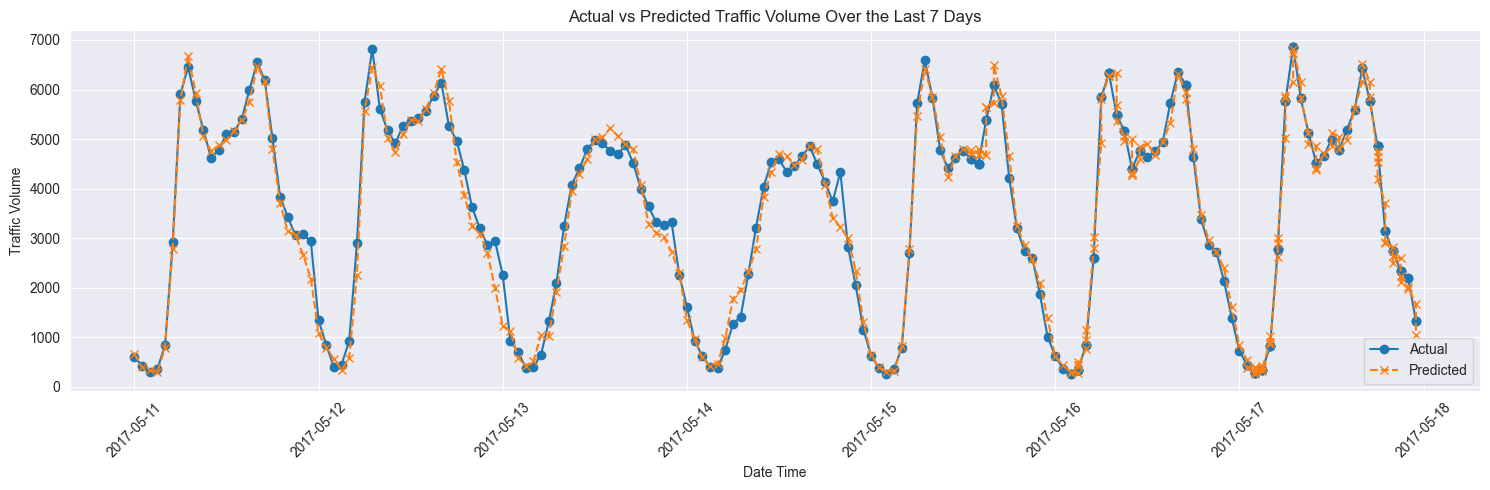

In [2]:
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are already defined and are pandas Series
comparison_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
comparison_df['date_time'] = y_test.index  # Assuming y_test still has the date_time index
comparison_df.set_index('date_time', inplace=True)

# Select the last 7 days of data for plotting
last_7_days = comparison_df.last('7D')  # '7D' for 7 days

# Plot the results
plt.figure(figsize=(15, 5))
plt.plot(last_7_days['Actual'], label='Actual', marker='o')
plt.plot(last_7_days['Predicted'], label='Predicted', marker='x', linestyle='--')
plt.title('Actual vs Predicted Traffic Volume Over the Last 7 Days')
plt.xlabel('Date Time')
plt.ylabel('Traffic Volume')
plt.legend()
plt.xticks(rotation=45)  # Rotate the x-axis labels for better readability
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()
